In [1]:
import io
import h5py
import argparse
import torch
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from datetime import timedelta
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from sklearn.neighbors import NearestNeighbors

In [2]:
from pathlib import Path
import tqdm
import cv2
import nltk
!pip install --upgrade keras -q
import keras
import torch
import pandas as pd
!pip install --upgrade diffusers transformers -q
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 12.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.3 MB/s eta 0:00:00


In [3]:
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [4]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(128),  # Alternative resize value
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Alternative normalization values using mean and standard deviation
])

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader  # Import DataLoader
dataset = CIFAR10(root='./data/cifar10', train=True, transform=transform, download=True)

# Adjust batch size and add number of workers for DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

# Now you can use 'dataloader' in your training loop
for images, labels in dataloader:
    # Training code here
    pass


100%|██████████| 170498071/170498071 [00:05<00:00, 32351663.43it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

num_gpus = torch.cuda.device_count()
print(f"Number of available GPUs: {num_gpus}")

Using device: cuda
Number of available GPUs: 1


In [7]:
import nltk
from nltk.tokenize import word_tokenize
import torch.nn as nn

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_channels, base_feature_size):
        """
        Generator Class

        Parameters:
        latent_dim (int): Dimension of the latent vector (input noise).
        num_channels (int): Number of channels in the output image (e.g., 3 for RGB images).
        base_feature_size (int): Size of the base feature maps in the generator. This parameter
                                 controls the number of feature maps in the intermediate layers.
        """
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # Input is the latent vector Z.
            nn.ConvTranspose2d(latent_dim, base_feature_size * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(base_feature_size * 16),
            nn.ReLU(True),

            # State size: (base_feature_size * 16) x 4 x 4
            nn.ConvTranspose2d(base_feature_size * 16, base_feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_feature_size * 8),
            nn.ReLU(True),

            # State size: (base_feature_size * 8) x 8 x 8
            nn.ConvTranspose2d(base_feature_size * 8, base_feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_feature_size * 4),
            nn.ReLU(True),

            # State size: (base_feature_size * 4) x 16 x 16
            nn.ConvTranspose2d(base_feature_size * 4, base_feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_feature_size * 2),
            nn.ReLU(True),

            # State size: (base_feature_size * 2) x 32 x 32
            nn.ConvTranspose2d(base_feature_size * 2, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output state size: (num_channels) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [9]:
    def forward(self, input):
        return self.main(input)

In [10]:

class Discriminator(nn.Module):
    def __init__(self, num_channels, base_feature_size):

        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # Input is (num_channels) x 64 x 64
            nn.Conv2d(num_channels, base_feature_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (base_feature_size) x 32 x 32
            nn.Conv2d(base_feature_size, base_feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_feature_size * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (base_feature_size * 2) x 16 x 16
            nn.Conv2d(base_feature_size * 2, base_feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (base_feature_size * 4) x 8 x 8
            nn.Conv2d(base_feature_size * 4, base_feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (base_feature_size * 8) x 4 x 4
            nn.Conv2d(base_feature_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Output state size: 1 x 1 x 1
        )

    def forward(self, input):
        return self.main(input)

In [11]:

latent_dim = 100
base_feature_size = 64
num_channels = 3
learning_rate = 0.0003
beta1 = 0.5

# Initialize the models with new hyperparameters
netG = Generator(latent_dim, num_channels, base_feature_size)
netD = Discriminator(num_channels, base_feature_size)

netG.to(device)
netD.to(device)

# Print the models to verify the structure
print(netG)
print(netD)

# Define the optimizer with new hyperparameters
optimizerD = torch.optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))


#Loss
criterion = nn.BCELoss()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


In [12]:
n_epochs = 5

for epoch in range(n_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)

        # Forward pass real batch through Discriminator
        output = netD(real_cpu)

        # Create labels for real data (1s) and make sure they match the size of the output
        label_real = torch.full(output.size(), 1., dtype=torch.float, device=device)
        errD_real = criterion(output, label_real)
        errD_real.backward()
        D_x = output.mean().item()

        # Generate fake images batch with Generator
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake = netG(noise)

        # Forward pass fake batch through Discriminator
        output = netD(fake.detach())

        # Create labels for fake data (0s) and make sure they match the size of the output
        label_fake = torch.full(output.size(), 0., dtype=torch.float, device=device)
        errD_fake = criterion(output, label_fake)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Combine the loss and update the Discriminator
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator
        netG.zero_grad()

        # Forward pass fake batch through Discriminator again
        output = netD(fake)

        # We want the generator to fool the discriminator, so labels are real (1s)
        label_fake.fill_(1.)
        errG = criterion(output, label_fake)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print(f'[{epoch}/{n_epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item()} Loss_G: {errG.item()} D(x): {D_x} D(G(z)): {D_G_z1} / {D_G_z2}')

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[0/5][0/782] Loss_D: 1.390896201133728 Loss_G: 6.3426833152771 D(x): 0.45920026302337646 D(G(z)): 0.4390864968299866 / 0.0018479463178664446
[0/5][50/782] Loss_D: 0.3413390517234802 Loss_G: 16.437623977661133 D(x): 0.9744404554367065 D(G(z)): 0.2679898142814636 / 8.401214302011795e-08
[0/5][100/782] Loss_D: 0.038164932280778885 Loss_G: 5.663041114807129 D(x): 0.9771677851676941 D(G(z)): 0.012859109789133072 / 0.0045135123655200005
[0/5][150/782] Loss_D: 0.011979220435023308 Loss_G: 6.476497173309326 D(x): 0.9937043786048889 D(G(z)): 0.005429318640381098 / 0.002034352160990238
[0/5][200/782] Loss_D: 0.010679122060537338 Loss_G: 6.724703311920166 D(x): 0.9944039583206177 D(G(z)): 0.0048994263634085655 / 0.0013917444739490747
[0/5][250/782] Loss_D: 0.0046178787015378475 Loss_G: 6.903225898742676 D(x): 0.9973794221878052 D(G(z)): 0.0019453035201877356 / 0.0011466174619272351
[0/5][300/782] Loss_D: 0.006425613071769476 Loss_G: 6.743082046508789 D(x): 0.9959633946418762 D(G(z)): 0.0022480245

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


[1/5][0/782] Loss_D: 0.0005716122104786336 Loss_G: 8.72920036315918 D(x): 0.9996487498283386 D(G(z)): 0.00021956601995043457 / 0.00016515434253960848
[1/5][50/782] Loss_D: 0.0004333921824581921 Loss_G: 8.940704345703125 D(x): 0.999729573726654 D(G(z)): 0.00016260010306723416 / 0.00013382259930949658
[1/5][100/782] Loss_D: 0.00043909461237490177 Loss_G: 8.875941276550293 D(x): 0.9997352361679077 D(G(z)): 0.0001739484432619065 / 0.00014352117432281375
[1/5][150/782] Loss_D: 0.0004440021584741771 Loss_G: 8.765162467956543 D(x): 0.9997475743293762 D(G(z)): 0.00019111999426968396 / 0.00015828361210878938
[1/5][200/782] Loss_D: 0.000259231252130121 Loss_G: 9.253334045410156 D(x): 0.9998539686203003 D(G(z)): 0.00011309889669064432 / 9.806383604882285e-05
[1/5][250/782] Loss_D: 0.00020174492965452373 Loss_G: 9.631755828857422 D(x): 0.9998708963394165 D(G(z)): 7.25832796888426e-05 / 6.678475619992241e-05
[1/5][300/782] Loss_D: 0.00020139578555244952 Loss_G: 9.252778053283691 D(x): 0.99991071224

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Enter a prompt which you want to be generated Astronaut


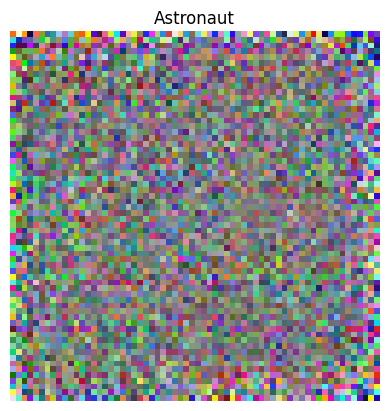

In [13]:
nltk.download('punkt')

# Function to convert text to noise
def text_to_noise(prompt, nz):
    tokens = word_tokenize(prompt)
    noise = torch.zeros(1, nz, 1, 1)
    for i, token in enumerate(tokens):
        noise[0, i % nz, 0, 0] = hash(token) % 1000 / 1000.0
    return noise

# Function to generate image from text prompt
def generate_image(prompt, generator, nz, device):
    noise = text_to_noise(prompt, nz).to(device)
    with torch.no_grad():
        fake_image = generator(noise).detach().cpu()

    img = fake_image[0].permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    plt.imshow(img)
    plt.axis('off')
    plt.title(prompt)
    plt.show()

# User input
prompt = input("Enter a prompt which you want to be generated ")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Adjusted hyperparameters
latent_dim = 100

# Assuming netG is already defined and loaded with trained weights
generate_image(prompt, netG, latent_dim, device)